# Excercise - Creating our own custom Model

This is a notebook that provides a quick overview of how to create your own custom model. You will be creating a simple model.
You will be utilizing Keras and Tensorflow


## Water Quality Dataset

This dataset contains water quality measurements and assessments related to potability, which is the suitability of water for human consumption. The dataset's primary objective is to provide insights into water quality parameters and assist in determining whether the water is potable or not. Each row in the dataset represents a water sample with specific attributes, and the "Potability" column indicates whether the water is suitable for consumption.

https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability?select=water_potability.csv


In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score, accuracy_score
import seaborn as sns

In [69]:
#LOAD THE DATA
df = pd.read_csv("water_potability.csv")

df.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [70]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [71]:
# Get the number of mising values in each column
df.isnull().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [72]:
# Fill up the missing values using the mean
df = df.fillna(df.mean())

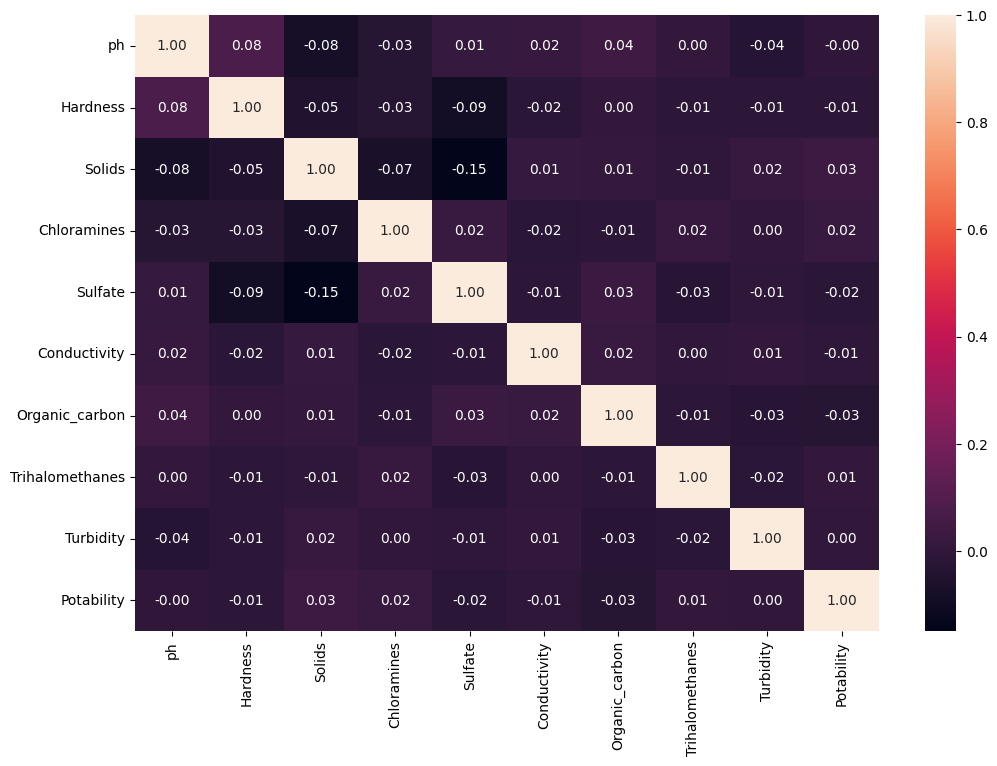

In [73]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

In [74]:
# Get the number of portable and non-portable water
df['Potability'].value_counts()

,count
Potability,
0,1998
1,1278


In [75]:
# Extract features and labels

X = df.drop("Potability", axis=1)
Y = df["Potability"]

In [76]:
X_remain, testX, y_remain, testY = train_test_split(X, Y, test_size=0.15)
trainX, valX, trainY, valY = train_test_split(X_remain, y_remain, test_size=0.15)

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
trainX = scaler.fit_transform(X=trainX)

valX = scaler.transform(valX)
testX = scaler.transform(testX)

trainX = np.clip(trainX, -5, 5)
valX = np.clip(valX, -5, 5)
testX = np.clip(testX, -5, 5)

In [78]:
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l1(0.001)),
    Dropout(0.2),

    Dense(64, activation="relu", kernel_regularizer=l1(0.001)),
    Dropout(0.2),

    Dense(32, activation="relu", kernel_regularizer=l1(0.001)),
    Dropout(0.2),

    Dense(1, activation="sigmoid")
])

# Early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Start the training Process

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6033 - loss: 1.7277 - val_accuracy: 0.6301 - val_loss: 1.5148
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6307 - loss: 1.4514 - val_accuracy: 0.6463 - val_loss: 1.2753
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6338 - loss: 1.2236 - val_accuracy: 0.6443 - val_loss: 1.0842
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6553 - loss: 1.0449 - val_accuracy: 0.6626 - val_loss: 0.9535
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6558 - loss: 0.9244 - val_accuracy: 0.6626 - val_loss: 0.8682
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6667 - loss: 0.8520 - val_accuracy: 0.6748 - val_loss: 0.8052
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6779 - loss: 0.7987 - val_accuracy: 0.6707 - val_loss: 0.7676
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6637 - loss: 0.7645 - val_accuracy: 0.6911 - val_loss:

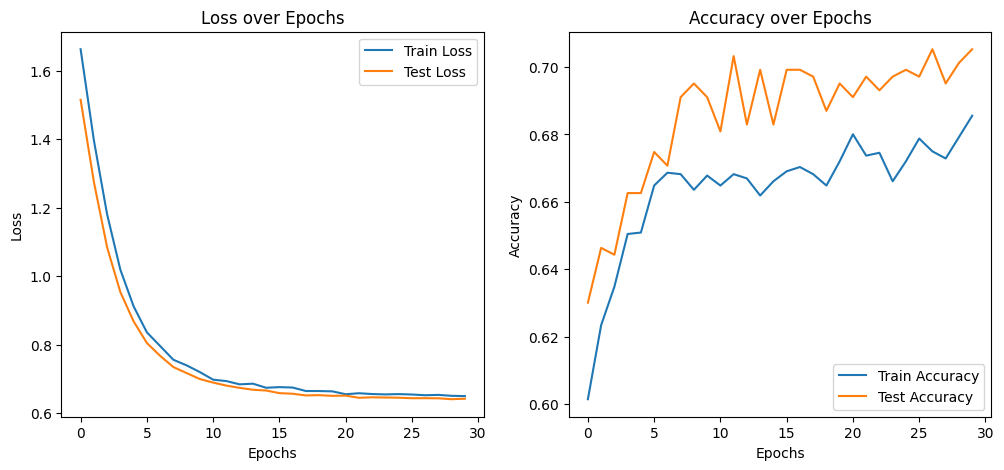

In [79]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(
    trainX,
    trainY,
    validation_data=(testX, testY),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Print available keys in history
print("Available history keys:", history.history.keys())

# Evaluate the model on training and test sets
train_eval = model.evaluate(trainX, trainY, verbose=0)
test_eval = model.evaluate(testX, testY, verbose=0)

train_loss, train_acc = train_eval[0], train_eval[1]
test_loss, test_acc = test_eval[0], test_eval[1]


# Results
print(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")

# Plot training history (Loss & Accuracy)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Test Loss')
ax[0].set_title("Loss over Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot Accuracy
ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Test Accuracy')
ax[1].set_title("Accuracy over Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

# Show plots
plt.show()

In [80]:
from sklearn.metrics import classification_report

y_pred = (model.predict(testX) > 0.5).astype(int)
print(classification_report(testY, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       302
           1       0.68      0.43      0.53       190

    accuracy                           0.70       492
   macro avg       0.69      0.65      0.65       492
weighted avg       0.70      0.70      0.68       492

